In [12]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.image as mpimg
from scipy.stats import shapiro
import ptitprince as pt
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

### Data processing 

In [13]:
# read in the data
df = pd.read_csv('../../data/user-study/prediction-model-labels-with-gsv-url-crowdstudy.csv')

In [14]:
df

,label_id,username,route_id,label_type,deleted,correct,time_created,lat,lng,canvas_x,canvas_y,gsv_url
0,1,mikey,NaN,CurbRamp,f,NaN,2019-03-04 11:59:59.576-08,38.940491,-77.067688,362,280,https://maps.googleapis.com/maps/api/streetvie...
1,2,mikey,NaN,CurbRamp,f,NaN,2019-03-04 12:00:05.267-08,38.940464,-77.067657,629,263,https://maps.googleapis.com/maps/api/streetvie...
2,3,mikey,NaN,NoCurbRamp,f,NaN,2019-03-04 12:00:06.453-08,38.940445,-77.067665,486,257,https://maps.googleapis.com/maps/api/streetvie...
3,4,mikey,NaN,CurbRamp,f,NaN,2019-03-04 12:00:11.136-08,38.940453,-77.067566,604,314,https://maps.googleapis.com/maps/api/streetvie...
4,5,mikey,NaN,CurbRamp,f,NaN,2019-03-04 12:00:12.01-08,38.940483,-77.067551,403,304,https://maps.googleapis.com/maps/api/streetvie...
...,...,...,...,...,...,...,...,...,...,...,...,...
6047,6039,aakashmr,8.0,NoCurbRamp,f,t,2023-08-22 13:16:50.986-07,47.685112,-122.371506,404,239,https://maps.googleapis.com/maps/api/streetvie...
6048,6049,Hailey,5.0,Obstacle,f,t,2023-08-22 13:16:20.218-07,47.607841,-122.284813,341,156,https://maps.googleapis.com/maps/api/streetvie...
6049,6040,Hailey,3.0,SurfaceProblem,f,t,2023-08-22 13:14:58.782-07,40.954971,-74.041519,439,169,https://maps.googleapis.com/maps/api/streetvie...
6050,6042,mclark111@gmail.com,14.0,CurbRamp,f,t,2023-08-22 13:15:09.195-07,47.657471,-122.319702,193,169,https://maps.googleapis.com/maps/api/streetvie...


In [15]:
def initial_processing (df):
    #replace username == 'ryandumrie' with 'ryandumire'
    df['username'] = df['username'].replace('ryandumrie', 'ryandumire')
    # take out route_id == nan and route_id == 8
    df = df[df['route_id'].notna()]
    df = df[df['route_id'] != 8]
    #select only CurbRamp, NoCurbRamp, Obstacle, SurfaceProblem and NoSidewalk
    df = df[df['label_type'].isin(['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem', 'NoSidewalk'])]
    return df

In [17]:
df = initial_processing(df)

In [26]:
len(df)

3763

In [27]:
#make a list of the control group user names
group_1 = ['wyatto', 'carina', 'Qingyu Chen', 'freedomeagle', 'newt', 'ehauptman', 'ccyn', 'ym2552', 'ktrevino', 'jke32', 'ywang3420', 'zixianma', 'danlil', 'mingyuanzhong', 'octipus', '0v0smiling', 'ylsheng']

In [28]:
#make a list of the following group user names
group_2 = ['aakashmr', 'kritikasony', 'samhross', 'mclark111@gmail.com', 'Hailey', 'bryanwang', 'peterchristenson', 'dinadawood', 'BJoseph', 'RT', 'amyhu1008', 'xzhu', 'ryandumire', 'sanjay vuppgandla', 'xavier160mg@gmail.com', 'Yi Li', 'rohankal']

In [29]:
#delete the rows that are not in group_1 or group_2
df = df[df['username'].isin(group_1 + group_2)]

In [30]:
len(df)

3763

In [25]:
df['deleted'].value_counts()

f    3574
t     189
Name: deleted, dtype: int64

### Overall precision

In [55]:
def precision_df(df):
    #take out the deleted labels
    df = df[df['deleted'] == 'f']
    #take out correct == Nan
    df = df[df['correct'].notna()]
    #take out route_id == Nan and route_id == 8
    df = df[df['route_id'].notna()]
    df = df[df['route_id'] != 8]
    #group by label_type and count correct = t and correct = f
    result = df.groupby('label_type').agg(
        count_t=('correct', lambda x: (x == 't').sum()),
        count_f=('correct', lambda x: (x == 'f').sum())
    ).reset_index()
    #add in another column for total and precision
    result['total'] = result['count_t'] + result['count_f']
    result['precision'] = (result['count_t'] / result['total']).round(3)
    #select only CurbRamp, NoCurbRamp, Obstacle, SurfaceProblem and NoSidewalk
    result = result[result['label_type'].isin(['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem', 'NoSidewalk'])]
    #add a row called 'overall'
    result.loc[len(result.index)] = ['overall', result['count_t'].sum(), result['count_f'].sum(), result['total'].sum(), (result['count_t'].sum() / result['total'].sum()).round(3)]
    return result

In [56]:
g1_df = df[df['username'].isin(group_1)]
g2_df = df[df['username'].isin(group_2)]

In [57]:
#control group precision
precision_df(g1_df)

,label_type,count_t,count_f,total,precision
0,CurbRamp,436,487,923,0.472
1,NoCurbRamp,265,61,326,0.813
2,NoSidewalk,94,17,111,0.847
3,Obstacle,309,124,433,0.714
4,SurfaceProblem,243,55,298,0.815
5,overall,1347,744,2091,0.644


In [58]:
#intervention group precision
precision_df(g2_df)

,label_type,count_t,count_f,total,precision
0,CurbRamp,454,23,477,0.952
1,NoCurbRamp,245,29,274,0.894
2,NoSidewalk,72,10,82,0.878
3,Obstacle,298,77,375,0.795
4,SurfaceProblem,249,26,275,0.905
5,overall,1318,165,1483,0.889


In [59]:
#get the precision for each user
def precision_user_df(df):
    #take out the deleted labels
    df = df[df['deleted'] == 'f']
    #take out correct == Nan
    df = df[df['correct'].notna()]
    #take out route_id == Nan and route_id == 8
    df = df[df['route_id'].notna()]
    df = df[df['route_id'] != 8]
    #group by label_type and count correct = t and correct = f
    result = df.groupby(['username', 'label_type']).agg(
        count_t=('correct', lambda x: (x == 't').sum()),
        count_f=('correct', lambda x: (x == 'f').sum())
    ).reset_index()
    #add in another column for total and precision
    result['total'] = result['count_t'] + result['count_f']
    result['precision'] = (result['count_t'] / result['total'])
    #select only CurbRamp, NoCurbRamp, Obstacle, SurfaceProblem and NoSidewalk
    result = result[result['label_type'].isin(['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem', 'NoSidewalk'])]
    return result

In [60]:
user = precision_user_df(df)
user['group'] = np.where(user['username'].isin(group_1), 1, 2)
user

,username,label_type,count_t,count_f,total,precision,group
0,0v0smiling,CurbRamp,25,81,106,0.235849,1
1,0v0smiling,NoCurbRamp,7,7,14,0.500000,1
2,0v0smiling,NoSidewalk,8,3,11,0.727273,1
3,0v0smiling,Obstacle,20,7,27,0.740741,1
4,0v0smiling,SurfaceProblem,7,0,7,1.000000,1
...,...,...,...,...,...,...,...
156,zixianma,CurbRamp,21,4,25,0.840000,1
157,zixianma,NoCurbRamp,13,2,15,0.866667,1
158,zixianma,NoSidewalk,6,0,6,1.000000,1
159,zixianma,Obstacle,12,1,13,0.923077,1


In [33]:
user.head(12)

,username,label_type,count_t,count_f,total,precision,group
0,0v0smiling,CurbRamp,25,81,106,0.235849,1
1,0v0smiling,NoCurbRamp,7,7,14,0.500000,1
2,0v0smiling,NoSidewalk,8,3,11,0.727273,1
3,0v0smiling,Obstacle,20,7,27,0.740741,1
4,0v0smiling,SurfaceProblem,7,0,7,1.000000,1
5,0v0smiling,overall,67,98,165,0.406061,1
6,BJoseph,CurbRamp,24,5,29,0.827586,2
7,BJoseph,NoCurbRamp,5,0,5,1.000000,2
8,BJoseph,NoSidewalk,5,0,5,1.000000,2
9,BJoseph,Obstacle,9,1,10,0.900000,2


In [61]:
# Function to calculate and append the new row for each group
def append_overall_row(group):
    overall_count_t = group['count_t'].sum()
    overall_count_f = group['count_f'].sum()
    overall_total = group['total'].sum()
    overall_precision = overall_count_t / (overall_count_f+ overall_count_t) if overall_count_f != 0 else None
    
    new_row = pd.Series({
        'username': group['username'].iloc[0],
        'label_type': 'overall',
        'count_t': overall_count_t,
        'count_f': overall_count_f,
        'total': overall_total,
        'precision': overall_precision,
        'group': group['group'].iloc[0]
    })
    
    return group.append(new_row, ignore_index=True)

In [62]:
user = user.groupby(['username', 'group']).apply(append_overall_row)

In [63]:
user.reset_index(drop=True, inplace=True)

<AxesSubplot: xlabel='precision', ylabel='Count'>

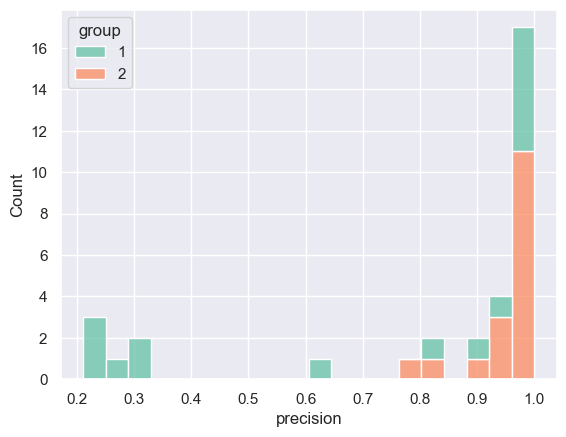

In [17]:
#histogram of precision, hue = group
sns.histplot(data=user[user['label_type']=="CurbRamp"], x='precision', hue='group', multiple='stack', bins=20, palette='Set2')


In [61]:
#set style white
sns.set_style('white')

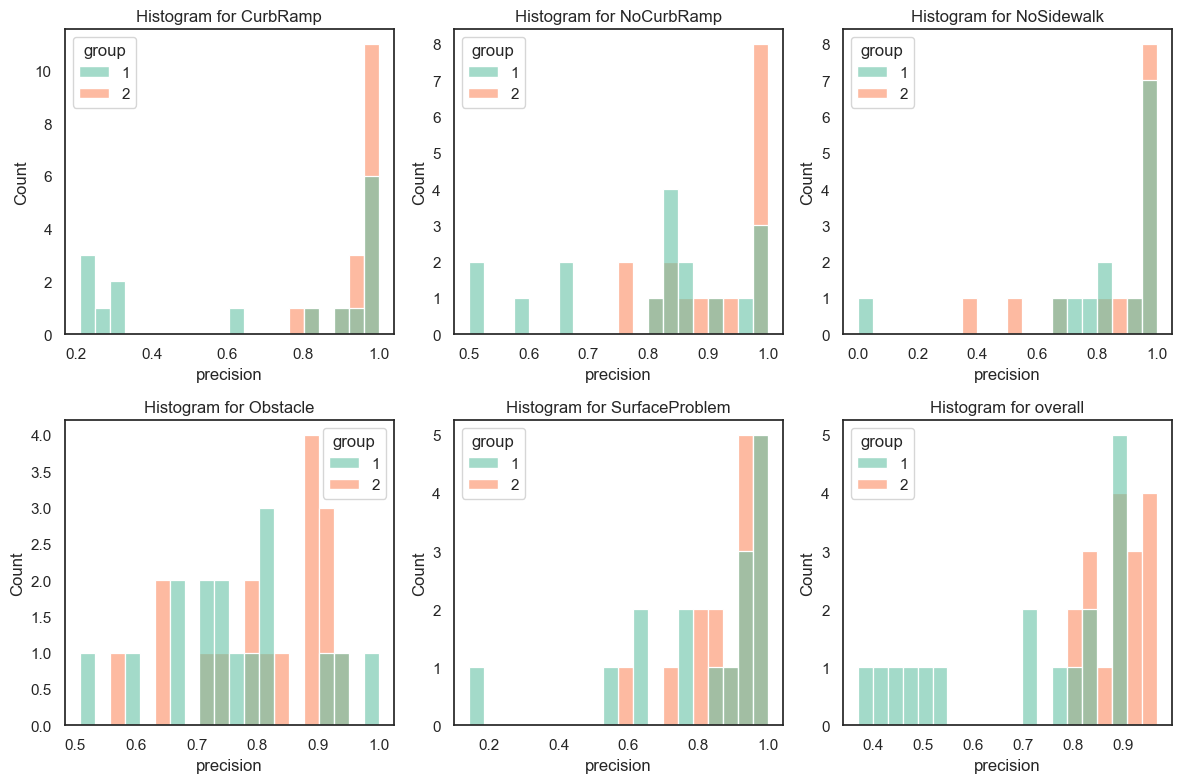

In [71]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the grid of subplots for easier indexing
axes = axes.flatten()

# Define the different label types you have
label_types = user['label_type'].unique().tolist()

# Iterate through the label types and plot each in its own subplot
for ax, label_type in zip(axes, label_types):
    sns.histplot(data=user[user['label_type'] == label_type], x='precision', hue='group',
                #  multiple='stack', 
                  alpha = 0.6,
                 bins=20, palette='Set2', ax=ax)
    ax.set_title(f'Histogram for {label_type}')

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
#split user by group
user_g1 = user[user['group'] == 1]
user_g2 = user[user['group'] == 2]

In [64]:
#pivot user so that each user is a row and each label_type is a column the value is the accuracy
user_pivot = user.pivot(index='username', columns='label_type', values='precision').reset_index()
#add in the overall column for each user
#user_pivot['overall'] = user_pivot[['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem', 'NoSidewalk']].mean(axis=1).round(3)
#add in the group column
user_pivot['group'] = np.where(user_pivot['username'].isin(group_1), 1, 2)
user_pivot 

label_type,username,CurbRamp,NoCurbRamp,NoSidewalk,Obstacle,SurfaceProblem,overall,group
0,0v0smiling,0.235849,0.500000,0.727273,0.740741,1.000000,0.406061,1
1,BJoseph,0.827586,1.000000,1.000000,0.900000,0.818182,0.866667,2
2,Hailey,1.000000,1.000000,NaN,0.913043,0.809524,0.929412,2
3,Qingyu Chen,0.641509,0.500000,0.909091,0.714286,0.888889,0.727273,1
4,RT,0.968750,0.750000,1.000000,0.651163,0.931818,0.829787,2
5,Yi Li,1.000000,0.888889,1.000000,0.888889,0.947368,0.942529,2
6,aakashmr,1.000000,1.000000,NaN,0.714286,0.875000,0.902778,2
7,amyhu1008,0.764706,0.818182,0.800000,0.739130,1.000000,0.802326,2
8,bryanwang,0.925926,1.000000,NaN,0.937500,1.000000,0.941176,2
9,carina,1.000000,0.827586,1.000000,0.807692,0.941176,0.900000,1


In [65]:
#split the dataframe into two based on group
user_pivot_1 = user_pivot[user_pivot['group'] == 1]
user_pivot_2 = user_pivot[user_pivot['group'] == 2]

In [104]:
#save user_pivot_2 to csv
user_pivot_2.to_csv('../../data/user-study/intervention-group-precision.csv', index=False)

In [29]:
#get the mean, median, std for each label_type and put into a dataframe
def get_stats(df):
    result = df.describe().transpose().reset_index()
    result = result[['label_type','mean', '50%', 'std', 'min', 'max']].round(3)
    result = result.rename(columns={'50%': 'median'})
    return result


In [30]:
get_stats(user_pivot_1)

,label_type,mean,median,std,min,max
0,CurbRamp,0.686,0.878,0.346,0.211,1.000
1,NoCurbRamp,0.802,0.833,0.164,0.500,1.000
2,NoSidewalk,0.842,0.955,0.267,0.000,1.000
3,Obstacle,0.760,0.759,0.126,0.508,1.000
4,SurfaceProblem,0.812,0.906,0.230,0.143,1.000
5,overall,0.699,0.761,0.199,0.370,0.903
6,group,1.000,1.000,0.000,1.000,1.000


In [31]:
get_stats(user_pivot_2)

,label_type,mean,median,std,min,max
0,CurbRamp,0.956,0.971,0.067,0.765,1.000
1,NoCurbRamp,0.918,0.933,0.091,0.750,1.000
2,NoSidewalk,0.867,1.000,0.208,0.375,1.000
3,Obstacle,0.812,0.833,0.111,0.571,0.938
4,SurfaceProblem,0.894,0.932,0.116,0.571,1.000
5,overall,0.891,0.901,0.053,0.802,0.968
6,group,2.000,2.000,0.000,2.000,2.000


### Shapiro-Wilk test for normal distribution

In [107]:
for i in ['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem', 'NoSidewalk', 'overall']:
    group_1 = user_pivot_1[i].dropna()
    group_2 = user_pivot_2[i].dropna()
    print(i)
    print(shapiro(group_1))
    print(shapiro(group_2))

CurbRamp
ShapiroResult(statistic=0.7570735216140747, pvalue=0.0007739731227047741)
ShapiroResult(statistic=0.7014297246932983, pvalue=0.00011999838170595467)
NoCurbRamp
ShapiroResult(statistic=0.8996766209602356, pvalue=0.06708254665136337)
ShapiroResult(statistic=0.827343225479126, pvalue=0.004932695534080267)
Obstacle
ShapiroResult(statistic=0.9770496487617493, pvalue=0.9358444213867188)
ShapiroResult(statistic=0.8850600719451904, pvalue=0.03843836113810539)
SurfaceProblem
ShapiroResult(statistic=0.7959180474281311, pvalue=0.0024051680229604244)
ShapiroResult(statistic=0.8427059650421143, pvalue=0.008317421190440655)
NoSidewalk
ShapiroResult(statistic=0.6363192200660706, pvalue=8.712914859643206e-05)
ShapiroResult(statistic=0.7078226804733276, pvalue=0.000445761252194643)
overall
ShapiroResult(statistic=0.9140108823776245, pvalue=0.11693961918354034)
ShapiroResult(statistic=0.9298321604728699, pvalue=0.21624039113521576)


### Mann–Whitney U test

In [21]:
sns.set(style="whitegrid")

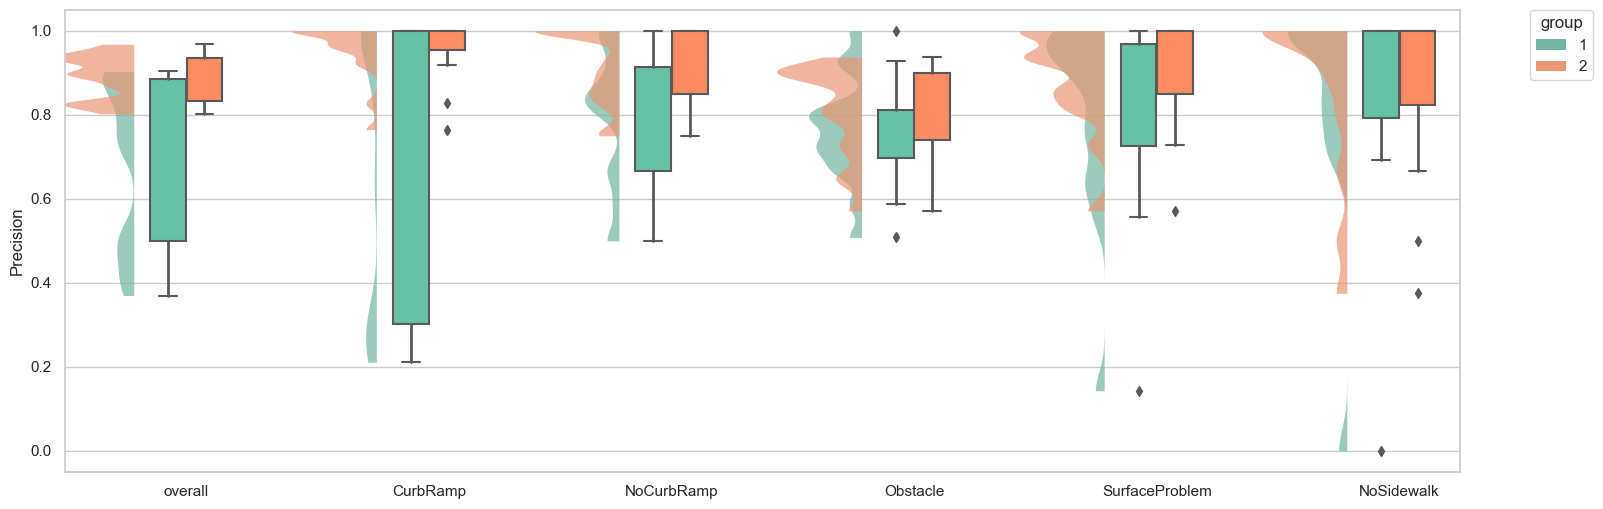

In [30]:
#set figure size
plt.figure(figsize=(18, 6))
pt.RainCloud(data=user, x="label_type", y="precision", hue="group", bw = .2, orient="v",dodge=True, linewidth=0, 
alpha=0.7, 
#move=.3, 
# offset=.1, 
width_viol=.7, palette="Set2", 
width_box=.3,
rain_alpha=0,
# box_sym='*',
order = ['overall','CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem', 'NoSidewalk'])
#change x to '' and y to precision
plt.xlabel('')
plt.ylabel('Precision')
#save as svg
#put the legent on top

plt.savefig('precision.svg', format='svg', dpi=1200)


In [142]:
user

,username,label_type,count_t,count_f,total,precision,group
0,0v0smiling,CurbRamp,25,81,106,0.236,1
1,0v0smiling,NoCurbRamp,7,7,14,0.500,1
2,0v0smiling,NoSidewalk,8,3,11,0.727,1
3,0v0smiling,Obstacle,20,7,27,0.741,1
4,0v0smiling,SurfaceProblem,7,0,7,1.000,1
...,...,...,...,...,...,...,...
156,zixianma,CurbRamp,21,4,25,0.840,1
157,zixianma,NoCurbRamp,13,2,15,0.867,1
158,zixianma,NoSidewalk,6,0,6,1.000,1
159,zixianma,Obstacle,12,1,13,0.923,1


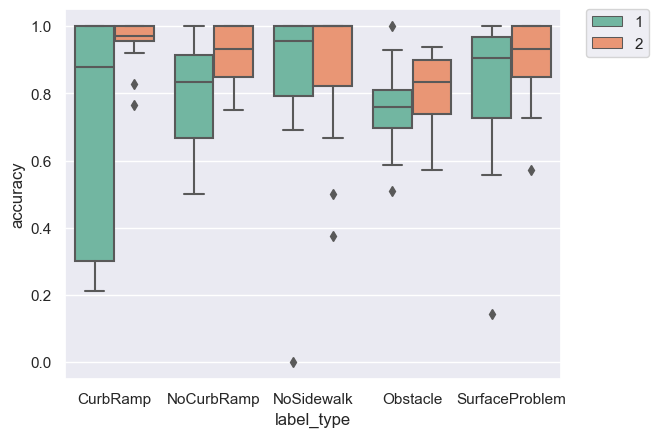

In [23]:
#create a boxplot for each label_type hue = group
sns.boxplot(x='label_type', y='precision', hue='group', data=user, palette="Set2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

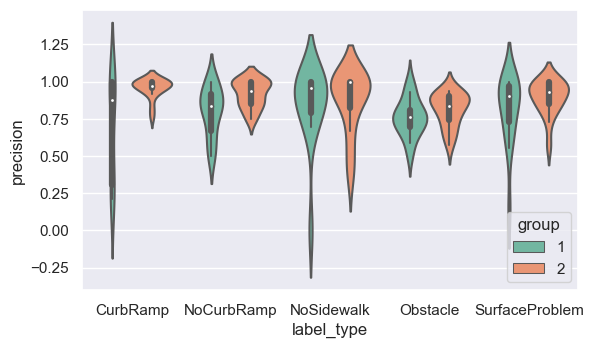

In [51]:
#create a violin plot for each label_type hue = group
sns.violinplot(x='label_type', y='precision', hue='group', data=user, palette="Set2")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set the aspect ratio
plt.gca().set_aspect(1.5)

In [74]:
#remove outliers for each column, replace with NaN
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high), col_name] = np.nan
    return df_in

In [66]:
user_pivot

label_type,username,CurbRamp,NoCurbRamp,NoSidewalk,Obstacle,SurfaceProblem,overall,group
0,0v0smiling,0.235849,0.500000,0.727273,0.740741,1.000000,0.406061,1
1,BJoseph,0.827586,1.000000,1.000000,0.900000,0.818182,0.866667,2
2,Hailey,1.000000,1.000000,NaN,0.913043,0.809524,0.929412,2
3,Qingyu Chen,0.641509,0.500000,0.909091,0.714286,0.888889,0.727273,1
4,RT,0.968750,0.750000,1.000000,0.651163,0.931818,0.829787,2
5,Yi Li,1.000000,0.888889,1.000000,0.888889,0.947368,0.942529,2
6,aakashmr,1.000000,1.000000,NaN,0.714286,0.875000,0.902778,2
7,amyhu1008,0.764706,0.818182,0.800000,0.739130,1.000000,0.802326,2
8,bryanwang,0.925926,1.000000,NaN,0.937500,1.000000,0.941176,2
9,carina,1.000000,0.827586,1.000000,0.807692,0.941176,0.900000,1


In [177]:
user_pivot_1

label_type,username,CurbRamp,NoCurbRamp,NoSidewalk,Obstacle,SurfaceProblem,overall,group
0,0v0smiling,0.236,0.500,0.727,0.741,1.000,0.406061,1
3,Qingyu Chen,0.642,0.500,0.909,0.714,0.889,0.727273,1
9,carina,1.000,0.828,1.000,0.808,0.941,0.900000,1
10,ccyn,1.000,0.800,0.692,0.784,0.842,0.834951,1
11,danlil,0.307,0.952,1.000,0.929,1.000,0.523179,1
13,ehauptman,NaN,0.833,NaN,1.000,0.652,0.718750,1
14,freedomeagle,1.000,0.913,1.000,0.810,0.765,0.893617,1
15,jke32,1.000,0.667,1.000,0.667,0.750,0.761468,1
17,ktrevino,0.326,0.586,0.778,0.733,0.633,0.500000,1
19,mingyuanzhong,0.917,0.865,0.833,NaN,NaN,0.886076,1


In [68]:
user_pivot_2.sort_values(by='overall', ascending=False)

label_type,username,CurbRamp,NoCurbRamp,NoSidewalk,Obstacle,SurfaceProblem,overall,group
25,samhross,0.970588,1.000000,1.000000,0.913043,1.000000,0.968085,2
28,xavier160mg@gmail.com,0.954545,0.933333,1.000000,0.800000,1.000000,0.954545,2
5,Yi Li,1.000000,0.888889,1.000000,0.888889,0.947368,0.942529,2
8,bryanwang,0.925926,1.000000,NaN,0.937500,1.000000,0.941176,2
26,sanjay vuppgandla,1.000000,0.866667,0.909091,0.882353,0.941176,0.934066,2
2,Hailey,1.000000,1.000000,NaN,0.913043,0.809524,0.929412,2
29,xzhu,1.000000,0.850000,0.666667,0.900000,1.000000,0.923077,2
6,aakashmr,1.000000,1.000000,NaN,0.714286,0.875000,0.902778,2
18,mclark111@gmail.com,1.000000,1.000000,1.000000,0.818182,0.850000,0.901099,2
24,ryandumire,0.967742,0.760000,1.000000,0.903226,0.937500,0.895238,2


In [84]:
for i in ['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem', 'NoSidewalk','overall']:
    user_pivot_1 = remove_outlier(user_pivot_1, i)
    group_1 =  user_pivot_1[i].tolist()
    user_pivot_2 = remove_outlier(user_pivot_2, i)
    group_2=  user_pivot_2[i].tolist()
    print(i)
    print(mannwhitneyu( group_1, group_2, alternative='two-sided', nan_policy='omit', use_continuity=False))

CurbRamp
MannwhitneyuResult(statistic=70.0, pvalue=0.03809496652386686)
NoCurbRamp
MannwhitneyuResult(statistic=80.5, pvalue=0.024878612672250368)
Obstacle
MannwhitneyuResult(statistic=85.5, pvalue=0.1834219080633216)
SurfaceProblem
MannwhitneyuResult(statistic=100.0, pvalue=0.4234354908089446)
NoSidewalk
MannwhitneyuResult(statistic=66.5, pvalue=0.4799729316398528)
overall
MannwhitneyuResult(statistic=50.0, pvalue=0.001134267980898135)


<AxesSubplot: xlabel='group', ylabel='overall'>

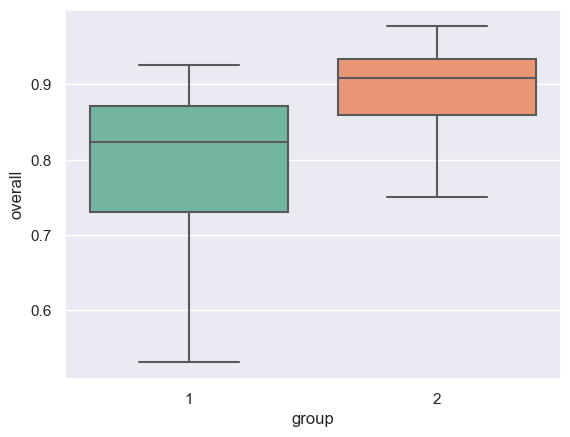

In [63]:
sns.boxplot(x='group', y='overall', data=  user_pivot, palette="Set2")